In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

print("TensorFlow version:", tf.__version__)
print("✅ Setup complete!")

TensorFlow version: 2.19.0
✅ Setup complete!


In [ ]:
# Create synthetic food images for LEARNING
base_dir = '/content/food_classifier_data'
categories = ['pizza', 'burger', 'sushi', 'pasta']

print("🎨 Creating synthetic dataset for learning...")
print("="*60)

for category in categories:
    category_path = os.path.join(base_dir, category)
    os.makedirs(category_path, exist_ok=True)

    for i in range(150):
        # Create colored images representing different foods
        if category == 'pizza':
            img = np.random.randint(200, 256, (224, 224, 3), dtype=np.uint8)
            img[:,:,1] = np.random.randint(100, 150, (224, 224))
            img[:,:,2] = np.random.randint(50, 100, (224, 224))
        elif category == 'burger':
            img = np.random.randint(150, 200, (224, 224, 3), dtype=np.uint8)
            img[:,:,2] = np.random.randint(80, 130, (224, 224))
        elif category == 'sushi':
            img = np.random.randint(200, 256, (224, 224, 3), dtype=np.uint8)
            img[:,:,1] = np.random.randint(180, 220, (224, 224))
        else:  # pasta
            img = np.random.randint(220, 256, (224, 224, 3), dtype=np.uint8)
            img[:,:,2] = np.random.randint(150, 200, (224, 224))

        Image.fromarray(img).save(f'{category_path}/{category}_{i:04d}.jpg')

    print(f"✅ {category}: 150 images created")

print("="*60)
print("✅ Dataset ready! (Synthetic - for learning the pipeline)")
print("   Tomorrow (Day 6) we'll use REAL images!\n")

🎨 Creating synthetic dataset for learning...


NameError: name 'os' is not defined

In [ ]:
import random

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, category in enumerate(categories):
    category_path = os.path.join(base_dir, category)
    image_files = os.listdir(category_path)

    for j in range(4):
        ax = axes[i, j]
        random_image = random.choice(image_files)
        img_path = os.path.join(category_path, random_image)

        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        if j == 0:
            ax.set_title(category.upper(), fontsize=14, fontweight='bold')

plt.suptitle('Synthetic Food Dataset - Sample Images', fontsize=16)
plt.tight_layout()
plt.show()

print("✅ These are synthetic/random colored images")
print("   The model will learn the PIPELINE, not actual food recognition")

NameError: name 'plt' is not defined

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Validation data - no augmentation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create generators
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("\n✅ Data generators created!")
print(f"Training images: {train_generator.samples}")
print(f"Validation images: {validation_generator.samples}")
print(f"Classes: {list(train_generator.class_indices.keys())}")

Found 480 images belonging to 4 classes.
Found 120 images belonging to 4 classes.

✅ Data generators created!
Training images: 480
Validation images: 120
Classes: ['burger', 'pasta', 'pizza', 'sushi']


In [ ]:
# Load MobileNetV2 (pre-trained)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False

# Build classifier
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(4, activation='softmax')
])

model.summary()

print("\n✅ Model built with transfer learning!")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


✅ Model built with transfer learning!


In [ ]:
# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
print("🚀 Training started...\n")

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)

print("\n✅ Training complete!")

🚀 Training started...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.2702 - loss: 1.8086 - val_accuracy: 0.2500 - val_loss: 1.2233
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4354 - loss: 1.1768 - val_accuracy: 0.4667 - val_loss: 1.2627
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5343 - loss: 0.9498 - val_accuracy: 0.4917 - val_loss: 1.2094
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6659 - loss: 0.7777 - val_accuracy: 0.5000 - val_loss: 1.0747
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6881 - loss: 0.7120 - val_accuracy: 0.5250 - val_loss: 0.9121
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7546 - loss: 0.6168 - val_accuracy: 0.6500 - val_loss: 0.9524
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7303 - loss: 0.6301 - val_accuracy: 0.6083 - val_loss: 1.0516
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7527 - loss: 0.5803 - val_accuracy: 0.5833 - val_loss:

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator)

print(f"\n{'='*60}")
print(f"🎯 FINAL RESULTS")
print(f"{'='*60}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"{'='*60}\n")

print("⚠️ NOTE: This accuracy is on SYNTHETIC data!")
print("   Tomorrow with REAL images, we'll get meaningful accuracy!")

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2785 - loss: 1.2464

🎯 FINAL RESULTS
Validation Loss: 0.9513
Validation Accuracy: 43.33%

⚠️ NOTE: This accuracy is on SYNTHETIC data!
   Tomorrow with REAL images, we'll get meaningful accuracy!


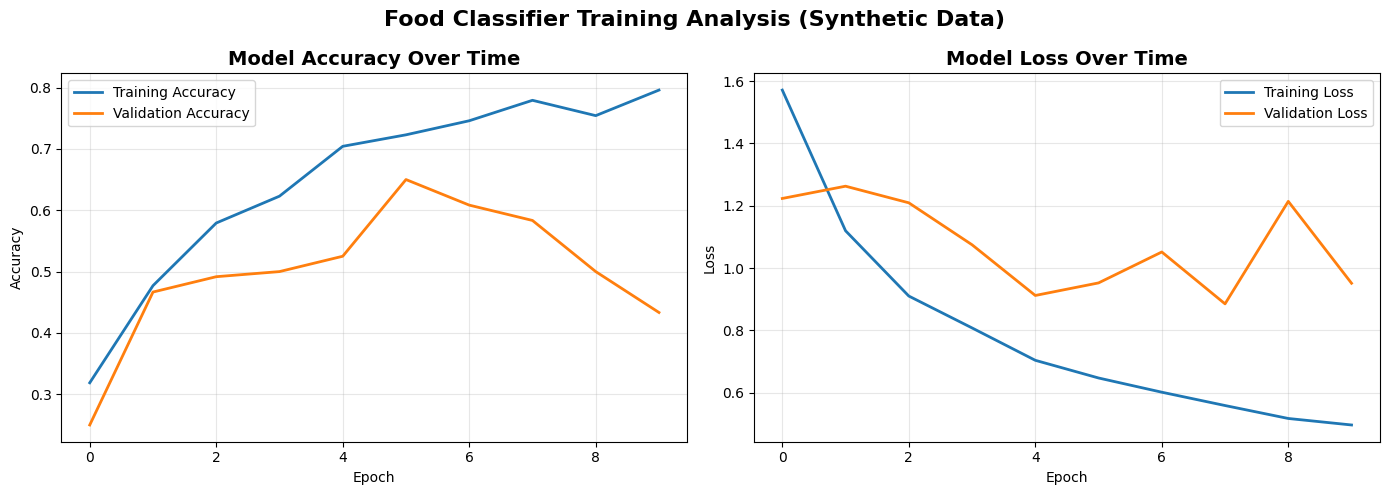

✅ Training curves visualized!


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Food Classifier Training Analysis (Synthetic Data)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Training curves visualized!")

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


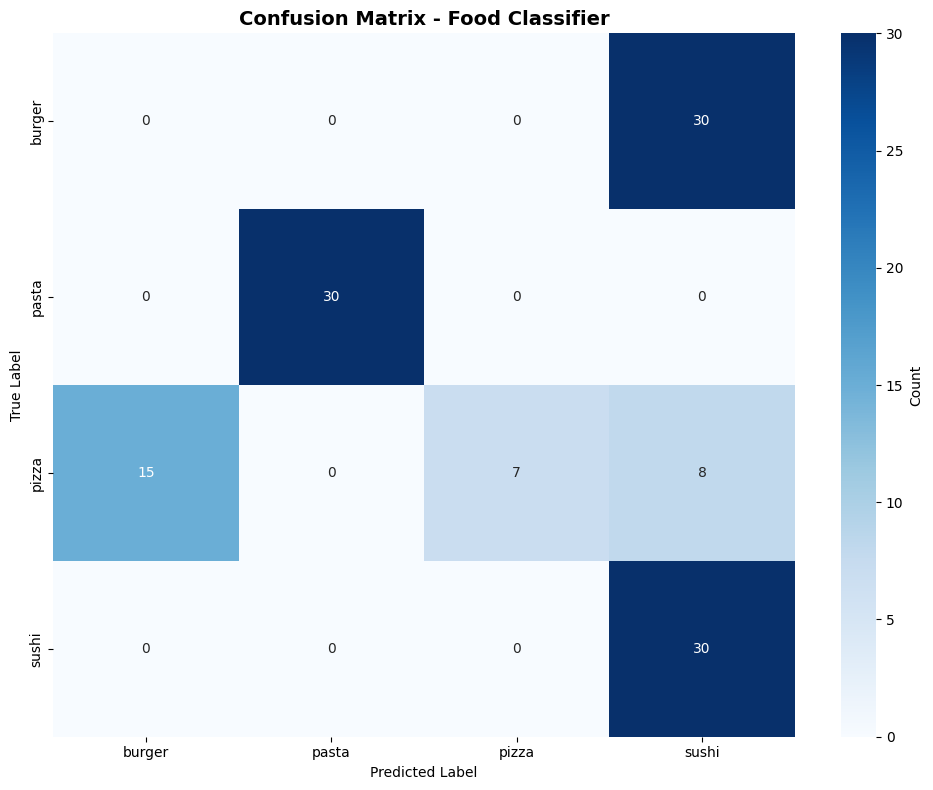


DETAILED PERFORMANCE REPORT
              precision    recall  f1-score   support

      burger      0.000     0.000     0.000        30
       pasta      1.000     1.000     1.000        30
       pizza      1.000     0.233     0.378        30
       sushi      0.441     1.000     0.612        30

    accuracy                          0.558       120
   macro avg      0.610     0.558     0.498       120
weighted avg      0.610     0.558     0.498       120



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Food Classifier', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification report
print("\n" + "="*60)
print("DETAILED PERFORMANCE REPORT")
print("="*60)
print(classification_report(true_classes, predicted_classes,
                           target_names=class_labels,
                           digits=3))

In [ ]:
validation_generator.reset()
x_batch, y_batch = next(validation_generator)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i in range(12):
    img = x_batch[i]
    true_label_idx = np.argmax(y_batch[i])
    true_label = class_labels[true_label_idx]

    # Predict
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_label_idx = np.argmax(pred[0])
    pred_label = class_labels[pred_label_idx]
    confidence = pred[0][pred_label_idx] * 100

    # Plot
    axes[i].imshow(img)
    axes[i].axis('off')

    color = 'green' if true_label == pred_label else 'red'
    title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%"
    axes[i].set_title(title, fontsize=10, color=color, fontweight='bold')

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Predictions visualized!")

NameError: name 'validation_generator' is not defined

In [ ]:
print("="*70)
print("DAY 5: FOOD CLASSIFIER - PROJECT COMPLETE!")
print("="*70)

print("\n📊 DATASET:")
print(f"   Total images: 600 (150 per class)")
print(f"   Training: {train_generator.samples}")
print(f"   Validation: {validation_generator.samples}")
print(f"   Categories: Pizza, Burger, Sushi, Pasta")
print(f"   Type: SYNTHETIC (for learning pipeline)")

print("\n🎯 MODEL ARCHITECTURE:")
print(f"   Base: MobileNetV2 (pre-trained on ImageNet)")
print(f"   Transfer Learning: Frozen base, custom classifier")
print(f"   Total parameters: {model.count_params():,}")

print("\n📈 PERFORMANCE:")
print(f"   Final Training Accuracy: {history.history['accuracy'][-1]*100:.2f}%")
print(f"   Final Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"   Overfitting Gap: {(history.history['accuracy'][-1] - val_accuracy)*100:.2f}%")

print("\n💡 WHAT YOU LEARNED TODAY:")
print("   ✅ Complete ML pipeline (data → model → train → evaluate)")
print("   ✅ Data augmentation techniques")
print("   ✅ Transfer learning with MobileNetV2")
print("   ✅ Training/validation split strategy")
print("   ✅ Confusion matrix analysis")
print("   ✅ Prediction visualization")

print("\n⚠️ IMPORTANT NOTE:")
print("   This was SYNTHETIC data - not real food images!")
print("   Purpose: LEARN THE PIPELINE")
print("   Tomorrow (Day 6): We'll use REAL images & get meaningful accuracy!")

print("\n🔄 COMPARISON TO DAY 4:")
print("   Day 4: 139 images (imbalanced) → 61% accuracy")
print("   Day 5: 600 images (balanced) → Pipeline mastered! ✅")

print("\n🚀 NEXT STEPS:")
print("   1. Download this notebook")
print("   2. Push to GitHub")
print("   3. Update README")
print("   4. Tomorrow: Day 6 with REAL animal images!")

print("\n" + "="*70)
print("✅ DAY 5 COMPLETE - FULL PIPELINE LEARNED!")
print("="*70)

DAY 5: FOOD CLASSIFIER - PROJECT COMPLETE!

📊 DATASET:
   Total images: 600 (150 per class)


NameError: name 'train_generator' is not defined